Start

## Imports and Reload

In [134]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from features.feature_engineering import build_feature_pipeline
from sklearn.model_selection import train_test_split
from features.encoder import ManualWOEEncoder as WOEEncoderWrapper
from features.proxy_target_engineering import ProxyTargetEngineer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [ ]:
# Load your data
df = pd.read_parquet('../../data/interim/clean_data.parquet')
df.sample(5)
df.columns

Index(['AccountId', 'CustomerId', 'ProviderId', 'ProductId', 'ProductCategory',
       'ChannelId', 'Amount', 'Value', 'TransactionStartTime',
       'PricingStrategy', 'FraudResult', 'transaction_hour', 'transaction_day',
       'transaction_month', 'transaction_weekday', 'is_large_transaction',
       'Amount_log', 'Amount_capped', 'is_outlier_Amount'],
      dtype='object')

## Train/Val Split

In [113]:
engineer = ProxyTargetEngineer(snapshot_date='2023-12-31')

high_risk_labels = engineer.transform(
    df,
    customer_id_col='CustomerId',
    date_col='TransactionStartTime', 
    amount_col='Amount'                    
)

df = df.merge(high_risk_labels, on='CustomerId', how='left')
df['is_high_risk'] = df['is_high_risk'].fillna(0).astype(int)


In [114]:
X = df.drop(columns=['is_high_risk'])  # drop target from features
y = df['is_high_risk']                  # new target

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [115]:
pipeline = build_feature_pipeline()
pipeline.fit(X_train, y_train)

Pipeline(steps=[('customer_agg', CustomerAggregates()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('datetime',
                                                  DateTimeFeaturesExtractor(column='TransactionStartTime'),
                                                  ['TransactionStartTime']),
                                                 ('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Amount', 'Value',
                                                   'Amount_log',
                                                   'Amount_capped',
                                                   'tot...
                                                   'std_transaction_amount']),
                                                 ('woe',
                                                  ManualWOEEncoder(features=['ProductCategory',
                                                                             'ChannelId',
                                                                             'ProviderId',
                                                                             'ProductId']),
                                                  ['ProductCategory',
                                                   'ChannelId', 'ProviderId',
                                                   'ProductId']),
                                                 ('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['PricingStrategy',
                                                   'is_large_transaction'])]))])

In [116]:
agg = pipeline.named_steps["customer_agg"].transform(X_train)

try:
    agg_feature_names = pipeline.named_steps["customer_agg"].get_feature_names_out()
except AttributeError:
    agg_feature_names = [
        "total_transaction_amount",
        "avg_transaction_amount",
        "transaction_count",
        "std_transaction_amount"
    ]


In [117]:
agg_df = pd.DataFrame(data=agg, columns=agg_feature_names, index=X_train.index)
X_train_augmented = X_train.join(agg_df)

In [118]:
X_train_augmented = X_train_augmented.merge(
    high_risk_labels,
    on='CustomerId',
    how='left'
)

X_train_augmented['is_high_risk'] = X_train_augmented['is_high_risk'].fillna(0).astype(int)


In [119]:
pipeline.named_steps["preprocessor"].fit(X_train_augmented, y_train)

ColumnTransformer(transformers=[('datetime',
                                 DateTimeFeaturesExtractor(column='TransactionStartTime'),
                                 ['TransactionStartTime']),
                                ('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['Amount', 'Value', 'Amount_log',
                                  'Amount_capped', 'total_transaction_amount',
                                  'avg_transaction_amount', 'transaction_count',
                                  's...nt']),
                                ('woe',
                                 ManualWOEEncoder(features=['ProductCategory',
                                                            'ChannelId',
                                                            'ProviderId',
                                                            'ProductId']),
                                 ['ProductCategory', 'ChannelId', 'ProviderId',
                                  'ProductId']),
                                ('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['PricingStrategy', 'is_large_transaction'])])

In [120]:
X_train_transformed = pipeline.named_steps["preprocessor"].transform(X_train_augmented)
print("Transformed shape:", X_train_transformed.shape)

Transformed shape: (76529, 23)


In [121]:
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
print("Feature names shape:", len(feature_names))

ct = pipeline.named_steps["preprocessor"]
passthrough_cols = ct.transformers_[-1][2]
print("Passthrough columns:", passthrough_cols)
print("Count:", len(passthrough_cols))

passthrough_cols_existing = [c for c in passthrough_cols if c in X_train_augmented.columns]
print("Existing passthrough cols:", passthrough_cols_existing)


Feature names shape: 23
Passthrough columns: [0, 1, 10, 11, 12, 13, 14, 18, 23]
Count: 9
Existing passthrough cols: []


In [122]:
processed_data = pd.DataFrame(
    X_train_transformed,
    columns=feature_names,
    index=X_train_augmented.index
)

processed_data["is_high_risk"] = X_train_augmented["is_high_risk"].values
processed_data["FraudResult"] = y_train.values  # keep original target if desired

print(processed_data.shape)
processed_data.head()


(76529, 25)


,datetime__TransactionStartTime_hour,datetime__TransactionStartTime_day,datetime__TransactionStartTime_month,datetime__TransactionStartTime_weekday,datetime__TransactionStartTime_year,numeric__Amount,numeric__Value,numeric__Amount_log,numeric__Amount_capped,numeric__total_transaction_amount,...,woe__ProviderId_woe,woe__ProductId_woe,onehot__PricingStrategy_0,onehot__PricingStrategy_1,onehot__PricingStrategy_2,onehot__PricingStrategy_4,onehot__is_large_transaction_0,onehot__is_large_transaction_1,is_high_risk,FraudResult
0,8.0,13.0,1.0,6.0,2019.0,-0.056453,-0.080693,-1.100214,-0.217245,0.324373,...,0.027348,0.033043,0.0,0.0,1.0,0.0,1.0,0.0,0,0
1,16.0,21.0,12.0,4.0,2018.0,-0.015089,-0.040890,0.721107,0.201962,0.144422,...,-0.041135,0.004047,0.0,0.0,1.0,0.0,1.0,0.0,0,0
2,18.0,23.0,1.0,2.0,2019.0,-0.047531,-0.073382,-0.029698,-0.126828,0.145476,...,-0.041135,-0.062728,0.0,0.0,1.0,0.0,1.0,0.0,0,0
3,11.0,12.0,1.0,5.0,2019.0,-0.056209,-0.080937,-1.264710,-0.214779,1.908076,...,0.027348,0.033043,0.0,0.0,1.0,0.0,1.0,0.0,0,0
4,7.0,8.0,2.0,4.0,2019.0,0.106567,0.080956,1.368067,1.434925,0.153514,...,-0.041135,0.004047,0.0,0.0,1.0,0.0,0.0,1.0,0,0


In [126]:
processed_data.to_parquet('../../data/processed/processed_data.parquet')

In [127]:
print("Distribution of is_high_risk:")
print(processed_data['is_high_risk'].value_counts(normalize=True))

Distribution of is_high_risk:
is_high_risk
0    0.957376
1    0.042624
Name: proportion, dtype: float64


[autoreload of features.feature_engineering failed: Traceback (most recent call last):
  File "/home/teshager/Documents/10Academy/repositories/projects/credit-risk-model-altdata/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/teshager/Documents/10Academy/repositories/projects/credit-risk-model-altdata/venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "

In [128]:
cross_tab = pd.crosstab(processed_data['is_high_risk'], processed_data['FraudResult'], margins=True)
print(cross_tab)

FraudResult       0     1    All
is_high_risk                    
0             73267     0  73267
1                 0  3262   3262
All           73267  3262  76529


In [129]:
correlation = processed_data[['is_high_risk', 'FraudResult']].corr().loc['is_high_risk', 'FraudResult']
print(f"Correlation between is_high_risk and FraudResult: {correlation:.4f}")

Correlation between is_high_risk and FraudResult: 1.0000


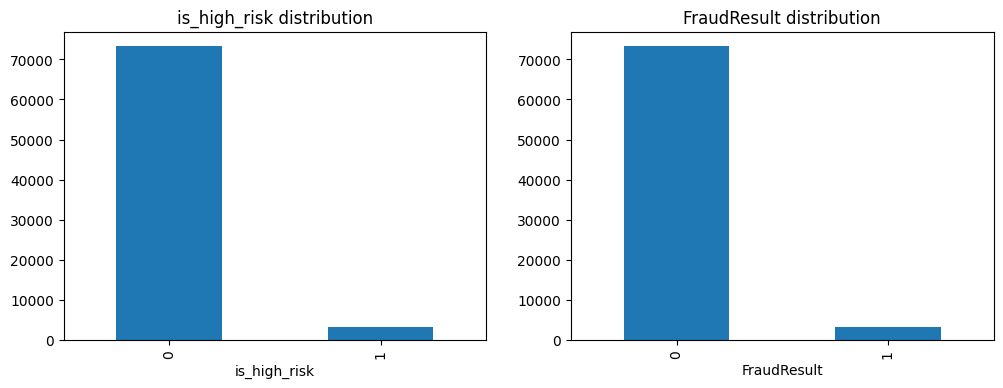

In [130]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,4))
processed_data['is_high_risk'].value_counts().plot(kind='bar', ax=ax[0], title='is_high_risk distribution')
processed_data['FraudResult'].value_counts().plot(kind='bar', ax=ax[1], title='FraudResult distribution')
plt.show()

In [133]:
rfm = engineer.calculate_rfm(
    df,
    customer_id_col="CustomerId",
    date_col="TransactionStartTime",
    amount_col="Amount"
)

rfm = rfm.merge(df.groupby("CustomerId")["FraudResult"].max().reset_index(), on="CustomerId", how="left")

print(rfm.groupby("FraudResult").mean(numeric_only=True)
)


                 Monetary  Frequency      Recency
FraudResult                                      
0            6.137164e+04  24.970445  1812.179230
1            7.709334e+06  66.129630  1808.574074
